### Autoregressive RNN With Softmax on Alanine Dipeptide

In [363]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.distributions as dist
import torch.optim as optim

from torch.utils.data import DataLoader
import sys
import os

In [364]:
## load required modules
## load MMCDataset class
## MMCD_path = "/path/to/MMCD"
MMCD_path = "./"
sys.path.append(MMCD_path)
from mmcd import MMCDataset

name = 'dialanine'
data_path = os.path.join(MMCD_path, "data")

dataset_train = MMCDataset(root = data_path,
                           molecule_name = name,
                           train = True,
                           coordinate_type = 'internal',
                           lazy_load = False)

train_loader = DataLoader(dataset_train,
                          num_workers = 1,
                          batch_size = 256, #256 is the default batch size
                          shuffle = True)

In [365]:
def flatten_data(data):
    """
    Input: data is a single dictionary item. In this case, for dialanine, it is a dictionary item 
    with six keys, each referencing a torch.tensor of size [256, 256, 256, (256, 19),(256, 19), (256, 19)]
    respectively. The batch size is 256, so the batch data is size [256, 256, 256, (256, 19), (256, 19), 
    (256, 19)]. Each dialiene molecule is  size [1, 1, 1, 19, 19, 19].
    
    Output: the dictionary item flattened into a 1-D tensor. It is a 1-D tensor of size 60
    for dialanine. We want a length 256 data object where each item is a 60-length 1-d tensor
    The resulting data object has shape: torch.Size of [256, 60].
    """
    result = torch.cat(
        [data['reference_particle_2_bond'][:, None],
         data['reference_particle_3_bond'][:, None],
         data['reference_particle_3_angle'][:, None],
         data['bond'], data['angle'], data['dihedral']],
        dim = -1)

    return result

def extract_ramachandran(data):
    result = torch.cat(
        [data['reference_particle_2_bond'][:, None],
         data['reference_particle_3_bond'][:, None],
         data['reference_particle_3_angle'][:, None],
         data['bond'], data['angle'], data['dihedral']],
        dim = -1)

    return result[:, [43,45]]

def rebuild(flat, data_length = 19):
    """
    Input: flattened tensor of torch.Size [256, 60], rebuild and return
    the original molecule, a dictionary item. The inverse of the flatten_data function.
    """
    data_length = 19 #this is particular to dialene
    result = {}

    result['reference_particle_1_xyz'] = torch.zeros((flat.shape[0], 3))
    result['reference_particle_2_bond'] = flat[:, 0]
    result['reference_particle_3_bond'] = flat[:, 1]
    result['reference_particle_3_angle'] = flat[:, 2]

    start = 3
    end = start + data_length
    result['bond'] = flat[:, start:end]

    start = end
    end = start + data_length
    result['angle'] = flat[:, start:end]

    start = end
    end = start + data_length
    result['dihedral'] = flat[:, start:end]

    return result

In [392]:
class InternalCoordinateSoftmaxJordanRNNv2(nn.Module):
    def __init__(self, batch_size = 256):
        super(InternalCoordinateSoftmaxJordanRNNv2, self).__init__()
        
        self.batch_size = 256
        self.hidden_size = 10

        #Size = [256, 1, 628]
        
        #Modules for everything that is not the first input.
        self.hidden_to_energy = nn.ModuleList([nn.Linear(10, 628) for index in range(21)]) #Energy
        self.energy_to_hidden = nn.ModuleList([nn.Linear(628, 10) for index in range(21)])
        self.x_to_hidden = nn.ModuleList([nn.Linear(1, 10) for index in range(21)])

        self.activation_function = torch.nn.Softmax(dim=1)
        self.loss_function = nn.CrossEntropyLoss()

    def forward(self, X):  
        h = torch.zeros(X.size()[0], self.hidden_size, 1).to(device) #[256, number_of_coordinates, 1]
        energy = self.energy[0](h[:, :, 0]) 
        
        return h, energy
    
    def sample(self, num_samples = 256):
        h = torch.zeros(num_samples, self.hidden_size, 1).to(device) #[256, number_of_coordinates, 1]
        energy = self.energy[0](h[:, :, 0])
        categorical = self.activation_function(energy)

        distribution = dist.Categorical(categorical) #like forward with two extra steps
        samples = distribution.sample()

        return categorical, samples

    def loss(self, X, Y, tensor_form = False):
        #X is a categorical distribution and Y is the target (one hot encoding).
        #this one gave me AIDs to solve
        #https://discuss.pytorch.org/t/cross-entropy-loss-for-a-sequence-time-series-of-output/4309
        
        loss_value = self.loss_function(X, Y)
        return loss_value        

### Training Loop

In [466]:
def number_to_vec(ic, num_decimals = 2):
    """
    [1.80, 1.84, 0.97] -> [180, 184, 097]
    """
    ic = torch.round(100*ic)
    ic = ic/100

    indicies = ic * 10**num_decimals + 314
    indicies = indicies.long()
    num_of_classes = 2 * 3.14 * 10**num_decimals
    one_hots = F.one_hot(indicies, num_classes = int(num_of_classes))

    return one_hots

def number_to_vec_class(ic, num_decimals = 2):
    """
    [1.80, 1.84, 0.97] -> [180, 184, 097]
    """
    ic = torch.round(100*ic)
    ic = ic/100

    indicies = ic * 10**num_decimals + 314
    indicies = indicies.long()

    return indicies

def vec_to_number(one_hots, num_decimals = 2):
    labels_again = (torch.argmax(one_hots, dim=2) -314)/100 #replace with dim=2 once u get it going
    return labels_again

In [395]:
device = torch.device("cuda")
model = InternalCoordinateSoftmaxJordanRNNv2().to(device)
optimizer = optim.Adam(model.parameters(), lr=2e-3)  #lr is step size, arbitrarily picked.

def train(epoch):
    model.train()
    train_loss = 0

    for batch_idx, (data, _) in enumerate(train_loader):
        #Flatten the data into a tensor of size (256, 60) tensor before putting it into the GPU
        data = flatten_data(data)

        data = number_to_vec_class(data[:, 43:44])

        true_target = data.squeeze()
        true_target = true_target.to(device)

        optimizer.zero_grad()

        h, X_pred = model(true_target) #h is the hidden layers, but it is useless

        loss = model.loss(X = X_pred, Y = true_target)
        
        loss.backward()

        train_loss += loss.item()
        optimizer.step()
        
        if batch_idx % 100 == 0:#args.log_interval == 0: #by default, args.log_interval = 10
            print('Train Epoch:', epoch, '[{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(

                #len(train_loader) should be 625
                batch_idx, #index of the batch we are on 
                len(train_loader), #how many batches are in the data loader
                100. * batch_idx / len(train_loader), #progress percentage
                loss.item() / len(train_loader))  #hardcoded batch size
                )

for epoch in range(1, 11):
    train(epoch)

    '''
    sample =  model.sample(1000)
    sample = rebuild(sample)
    potential_energy_q_theta = dataset_train.compute_potential_energy_for_ic(sample)
    print(np.sum(potential_energy_q_theta)/1000)
    '''

Train Epoch: 1 [0/625 (0%)]	Loss: 0.010283
Train Epoch: 1 [100/625 (16%)]	Loss: 0.010005
Train Epoch: 1 [200/625 (32%)]	Loss: 0.009755
Train Epoch: 1 [300/625 (48%)]	Loss: 0.009584
Train Epoch: 1 [400/625 (64%)]	Loss: 0.009390
Train Epoch: 1 [500/625 (80%)]	Loss: 0.009276
Train Epoch: 1 [600/625 (96%)]	Loss: 0.009197
Train Epoch: 2 [0/625 (0%)]	Loss: 0.009194
Train Epoch: 2 [100/625 (16%)]	Loss: 0.009048
Train Epoch: 2 [200/625 (32%)]	Loss: 0.008995
Train Epoch: 2 [300/625 (48%)]	Loss: 0.008957
Train Epoch: 2 [400/625 (64%)]	Loss: 0.008872
Train Epoch: 2 [500/625 (80%)]	Loss: 0.008912
Train Epoch: 2 [600/625 (96%)]	Loss: 0.008818
Train Epoch: 3 [0/625 (0%)]	Loss: 0.008842
Train Epoch: 3 [100/625 (16%)]	Loss: 0.008751
Train Epoch: 3 [200/625 (32%)]	Loss: 0.008800
Train Epoch: 3 [300/625 (48%)]	Loss: 0.008816
Train Epoch: 3 [400/625 (64%)]	Loss: 0.008597
Train Epoch: 3 [500/625 (80%)]	Loss: 0.008754
Train Epoch: 3 [600/625 (96%)]	Loss: 0.008881
Train Epoch: 4 [0/625 (0%)]	Loss: 0.008672


### Sample From Model to View Distribtuions

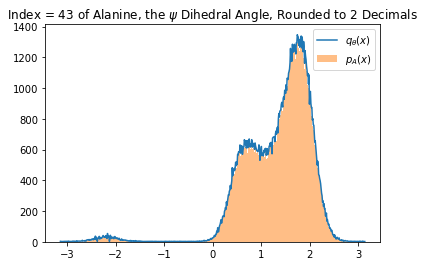

In [461]:
sample_loader = DataLoader(dataset_train,
                          num_workers = 4,
                          batch_size = 160000, #256 is the default batch size
                          shuffle = True)

for batch_idx, (data, _) in enumerate(sample_loader):
    data = flatten_data(data)
    break

np_data = np.array(data)
np_data_rounded = np.round(np.array(data), decimals=2)

categorical, samples = model.sample()

#43 and 45
line = np.array([(x-314)/100 for x in range(0, 628, 1)])
plt.plot(line, categorical[0, :].cpu().detach()*160000, label = "$q_{\\theta}(x)$")

for index in [43]:
    plt.hist(np_data[:, index], label = "$p_A(x)$", density=False, stacked=False, bins = 628, alpha = 0.5)
    #plt.hist(np_samples[:, index], label = "Learned", bins = 200, alpha = 0.5)
    categorical, samples = model.sample(256)
    #plt.plot(categorical[0, :].cpu().detach())
    plt.legend()
    plt.title("Index = " + str(index) + " of Alanine, the $\psi$ Dihedral Angle, Rounded to 2 Decimals")
    
    plt.show()

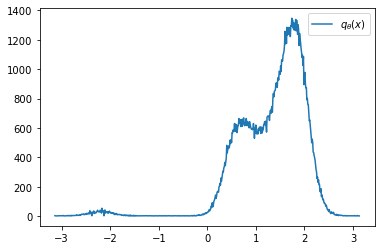

In [464]:
np_data = np.array(data)
np_data_rounded = np.round(np.array(data), decimals=2)

categorical, samples = model.sample()

#43 and 45
line = np.array([(x-314)/100 for x in range(0, 628, 1)])
plt.plot(line, categorical[0, :].cpu().detach()*160000, label = "$q_{\\theta}(x)$")
plt.legend()
plt.show()

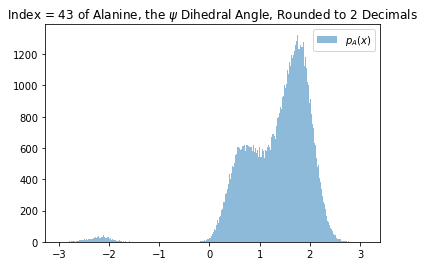

In [465]:
plt.hist(np_data[:, index], label = "$p_A(x)$", density=False, stacked=False, bins = 628, alpha = 0.5)
#plt.hist(np_samples[:, index], label = "Learned", bins = 200, alpha = 0.5)
categorical, samples = model.sample(256)
#plt.plot(categorical[0, :].cpu().detach())
plt.legend()
plt.title("Index = " + str(index) + " of Alanine, the $\psi$ Dihedral Angle, Rounded to 2 Decimals")
    
plt.show()

(10000, 2)


(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([-2.74570537e+00, -2.68964879e+00, -2.63359221e+00, -2.57753562e+00,
        -2.52147904e+00, -2.46542246e+00, -2.40936588e+00, -2.35330930e+00,
        -2.29725272e+00, -2.24119614e+00, -2.18513956e+00, -2.12908298e+00,
        -2.07302640e+00, -2.01696982e+00, -1.96091324e+00, -1.90485666e+00,
        -1.84880008e+00, -1.79274350e+00, -1.73668692e+00, -1.68063034e+00,
        -1.62457376e+00, -1.56851717e+00, -1.51246059e+00, -1.45640401e+00,
        -1.40034743e+00, -1.34429085e+00, -1.28823427e+00, -1.23217769e+00,
        -1.17612111e+00, -1.12006453e+00, -1.06400795e+00, -1.00795137e+00,
        -9.51894789e-01, -8.95838208e-01, -8.39781628e-01, -7.83725047e-01,
        -7.27668467e-01, -6.71611886e-01, -6.15555305e-01, -5.59498

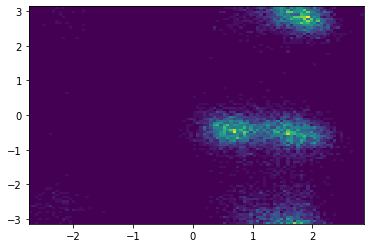

In [445]:
result = np_data[:, [43,45]]
print(np.shape(result))
plt.hist2d( x = result[:, 0], y = result[:, 1], bins = (100, 100) )